In [111]:
%load_ext autoreload
%autoreload 2
%run ~/FKMC/notebooks/notebook_preamble.py
%matplotlib inline
np.seterr(under = 'ignore')
from time import time
from munch import munchify
from FKMC.general import shapes 
from FKMC.plotting import spread

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Imported pathlib::Path, os, munch::Munch, pickle, logging, itertools::count, matplotlib::colors
Names are pyplot = plt, matplotlib = mpl, numpy = np


In [9]:
from FKMC.import_funcs import incremental_get_data_funcmap_chain_ext, incremental_load,IPRandDOS, mean_over_MCMC
from FKMC.general import smooth
from scipy.stats import sem

functions = [
    mean_over_MCMC('Mf_moments', N_error_bins = 10),
    IPRandDOS(),
]
o = incremental_load(folder = '~/HPC_data/gap_open_U=2', functions = functions, force_reload = False)

Ns = np.logspace(np.log10(70), np.log10(270), 10, dtype = np.int) // 10 * 10

Ns = np.array(o.Ns, dtype = np.int)
Ns

DEBUG:FKMC.import_funcs:todo: [141, 142]
DEBUG:FKMC.import_funcs:/rds/general/user/tch14/home/HPC_data/gap_open_U=2/data/141_0.npz is only partially finished.
DEBUG:FKMC.import_funcs:/rds/general/user/tch14/home/HPC_data/gap_open_U=2/data/142_0.npz is only partially finished.


141 142 

INFO:FKMC.import_funcs:########################################################################

INFO:FKMC.import_funcs:Observables has keys: dict_keys(['flat', 'hints', 'processed_task_ids', 'this_run', 'datapath', 'codepath', 'py_script', 'batch_params', 'structure_names', 'structure_dims', 'N_tasks', 'chains', 'N_chains', 'original_N_steps', 'thin', 'N_steps', 'E_bins', 'Ns', 'parameters', 'MCMC_params', 'structure_dimensions', 'chain_id', 'task_id', 'allow_pickle', 'desc', 'Rs', 'Ts', 'Mf_moments', 'DOS', 'IPR', 'dDOS', 'dIPR', 'time', 'accept_rates', 'proposal_rates', 'functions'])
INFO:FKMC.import_funcs:    Completed jobs:?
    MCMC Steps: 1 chains of 5000 for 5000 with thinning = 10 for 500 recorded steps
    Burn in: 5000
    Structure_names: {'Rs': 5, 'Ts': 50}
    Ns = [ 60. 120. 270.]
    Runtimes: 
        Average: 7.0 hours
        Min: 31.0 minutes
        Max: 1.0 days
        Total: 10.0 weeks
    
    


array([ 60, 120, 270])

## Random states, T = infinity

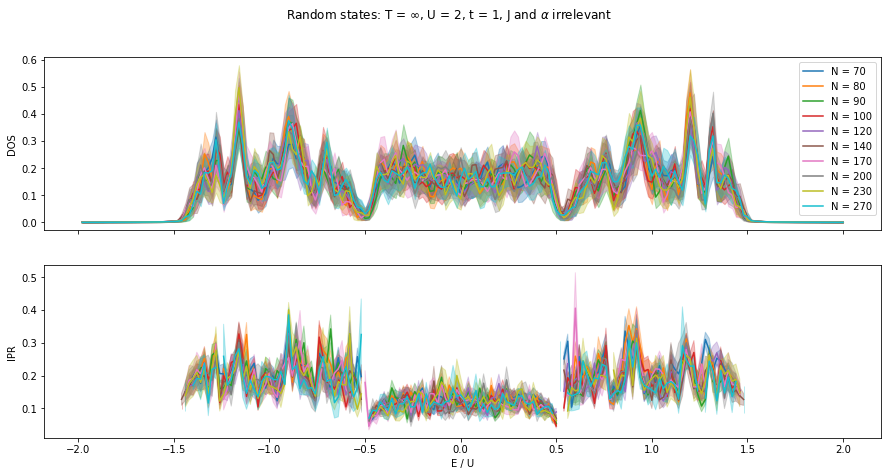

In [112]:
from shared_functions import solve_systems
from FKMC.general import interaction_matrix, solve_H_vectorised
from FKMC.general import index_histogram_array, sort_IPRs, normalise_IPR, smooth, get_nearby_index,  compute_IPR_and_DOS_histograms


energy_histogram_bins = np.linspace(-4, 4, 200 + 1)

N_states = int(1e3) # average over N_states // N replications
t = 1
U = 2

f, axes = plt.subplots(2,1, figsize = (15,7), sharex = 'col')

for N in Ns:
    M = N_states // N
    states = np.random.choice([1,0], size = (M,N)) #take 50-50 uncorrelated coin flips to simulate infinite temp limit.
    params = Munch(mu=0.0, beta = np.nan, U = U, t = t, N = N, alpha = 1.25, J = 1.0)
    scale = 10 / N
    
    N = states.shape[-1]
    params.J_matrix = interaction_matrix(**params)

    #NB the states argument should have only 1s and 0s
    #Fc is infinite at infinite temperature
    Ff, Fc, eigenvals, eigenvecs = solve_H_vectorised(states, **params)

    #calculate the IPR measure
    raw_IPRs = ((eigenvecs * np.conj(eigenvecs))**2).sum(axis = -2)

    DOS, dDOS, IPR, dIPR = compute_IPR_and_DOS_histograms(eigenvals, raw_IPRs, energy_histogram_bins, bootstrap_bins = 1)

    IPR = np.where(DOS > 0, IPR, np.NaN)
    dIPR = np.where(DOS > 0, dIPR, 0)
    
    #smooth out the spikey IPR values
    DOS = smooth(DOS, scale = scale, axis = -1)
    #IPR = smooth(IPR, scale = scale, axis = -1)
    
    dDOS = smooth(dDOS, scale = scale, axis = -1)
    #dIPR = smooth(dIPR, scale = scale, axis = -1)


    spread(axes[0], energy_histogram_bins[1:] / U, DOS, dDOS, label = f'N = {N}')
    spread(axes[1], energy_histogram_bins[1:] / U, IPR, dIPR)


f.suptitle(fr'Random states: T = $\infty$, U = {U}, t = {t}, J and $\alpha$ irrelevant')
axes[0].set(ylabel = 'DOS')    
axes[1].set(ylabel = 'IPR', xlabel = 'E / U')
axes[0].legend();

## Perfect CDW state

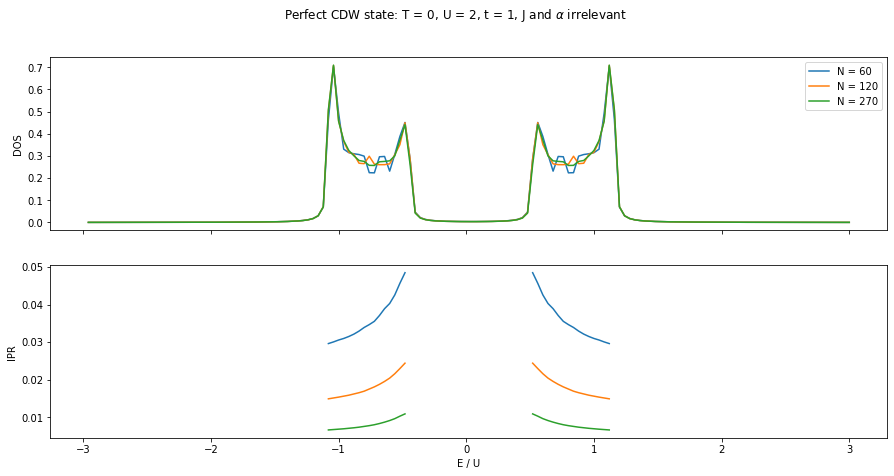

In [24]:
t = 1
U = 2

f, axes = plt.subplots(2,1, figsize = (15,7), sharex = 'col')

for N in Ns:
    alternating_sign = 2*(np.arange(N) % 2) - 1
    states = (alternating_sign + 1) // 2
    states.shape = (1, N)
    
    params = Munch(mu=0.0, beta = np.nan, U = U, t = t, N = N, alpha = 1.25, J = 1.0)
    energy_histogram_bins = np.linspace(-6, 6, 150 + 1)

    scale = 10 / N
    
    N = states.shape[-1]
    params.J_matrix = interaction_matrix(**params)

    #NB the states argument should have only 1s and 0s
    #Fc is infinite at infinite temperature
    Ff, Fc, eigenvals, eigenvecs = solve_H_vectorised(states, **params)

    #calculate the IPR measure
    raw_IPRs = ((eigenvecs * np.conj(eigenvecs))**2).sum(axis = -2)

    DOS, dDOS, IPR, dIPR = compute_IPR_and_DOS_histograms(eigenvals, raw_IPRs, energy_histogram_bins, bootstrap_bins = 1)

    IPR = np.where(DOS > 0, IPR, np.NaN)
    dIPR = np.where(DOS > 0, dIPR, 0)
    
    #smooth out the spikey IPR values
    DOS = smooth(DOS, scale = scale, axis = -1)
    #IPR = smooth(IPR, scale = scale, axis = -1)
    
    dDOS = smooth(dDOS, scale = scale, axis = -1)
    #dIPR = smooth(dIPR, scale = scale, axis = -1)
    
    spread(axes[0], energy_histogram_bins[1:] / U, DOS, dDOS, label = f'N = {N}')
    spread(axes[1], energy_histogram_bins[1:] / U, IPR, dIPR)


f.suptitle(fr'Perfect CDW state: T = 0, U = {U}, t = {t}, J and $\alpha$ irrelevant')
axes[0].set(ylabel = 'DOS')    
axes[1].set(ylabel = 'IPR', xlabel = 'E / U')
axes[0].legend();

Munch({'t': 1, 'alpha': 1.25, 'mu': 0, 'beta': 1.0, 'J': 5, 'U': 2, 'normalise': True, 'J_matrix': array([[ 0.        ,  0.70929615, -0.29824753, ...,  0.17969005,
        -0.29824753,  0.70929615],
       [ 0.70929615,  0.        ,  0.70929615, ..., -0.12544009,
         0.17969005, -0.29824753],
       [-0.29824753,  0.70929615,  0.        , ...,  0.09493123,
        -0.12544009,  0.17969005],
       ...,
       [ 0.17969005, -0.12544009,  0.09493123, ...,  0.        ,
         0.70929615, -0.29824753],
       [-0.29824753,  0.17969005, -0.12544009, ...,  0.70929615,
         0.        ,  0.70929615],
       [ 0.70929615, -0.29824753,  0.17969005, ..., -0.29824753,
         0.70929615,  0.        ]]), 'N': 270})


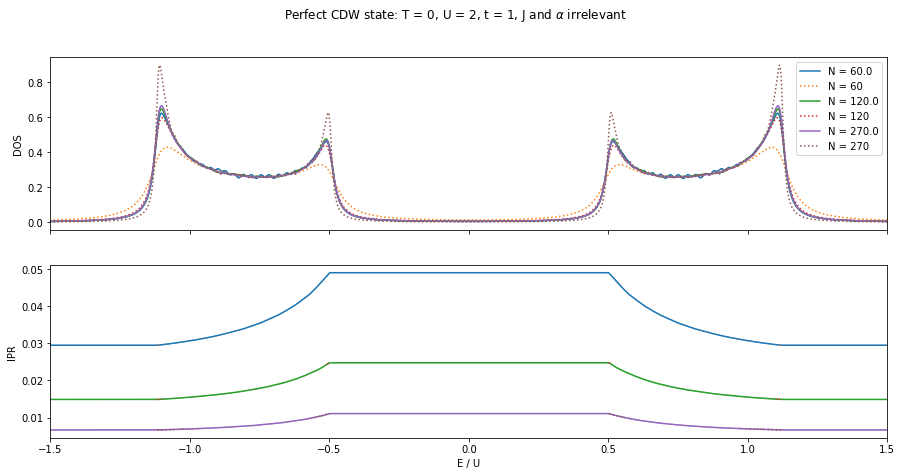

In [45]:
#Es = smooth(o.DOS.mean(axis = 1), scale = 0.7, axis = -1)
#dEs = smooth(sem(o.DOS, axis = 1), scale = 0.7, axis = -1)
#Is = smooth(o.IPR.mean(axis = 1), scale = 0.7, axis = -1)
#dIs = smooth(sem(o.IPR, axis = 1), scale = 0.7, axis = -1)

Es = o.DOS.mean(axis = 1)
dEs = sem(o.DOS, axis = 1)
Is = o.IPR.mean(axis = 1)
dIs = sem(o.IPR, axis = 1)

sEs = smooth(o.DOS.mean(axis = 1), scale = 0.7, axis = -1)
sdEs = smooth(sem(o.DOS, axis = 1), scale = 0.7, axis = -1)

f, axes = plt.subplots(2,1, figsize = (15,7), sharex = 'col')

T_i = 0
print(o.parameters)

for i,N in enumerate(o.Ns):
    ei = Es[i, T_i] > 0
    I = Is[i, T_i, ei]
    dI = dIs[i, T_i, ei]
    xI = o.E_bins[1:][ei]
    
    Iinterp = np.interp(o.E_bins[1:], xI, I)
    dIinterp = np.interp(o.E_bins[1:], xI, dI)
    #axes[1].scatter(xI, I, dI)
    
    
    spread(axes[0], o.E_bins[1:] / U, sEs[i, T_i], sdEs[i, T_i], label = f'N = {N}')
    spread(axes[1], o.E_bins[1:] / U, Iinterp, dIinterp)
    
    N = int(N)
    alternating_sign = 2*(np.arange(N) % 2) - 1
    states = (alternating_sign + 1) // 2
    states.shape = (1, N)
    
    params = o.parameters
    params.N = N


    scale = 100 / N
    N = states.shape[-1]
    params.J_matrix = interaction_matrix(**params)

    #NB the states argument should have only 1s and 0s
    #Fc is infinite at infinite temperature
    Ff, Fc, eigenvals, eigenvecs = solve_H_vectorised(states, **params)

    #calculate the IPR measure
    raw_IPRs = ((eigenvecs * np.conj(eigenvecs))**2).sum(axis = -2)

    DOS, dDOS, IPR, dIPR = compute_IPR_and_DOS_histograms(eigenvals, raw_IPRs, o.E_bins, bootstrap_bins = 1)

    IPR = np.where(DOS > 0, IPR, np.NaN)
    dIPR = np.where(DOS > 0, dIPR, 0)
    
    #smooth out the spikey IPR values
    DOS = smooth(DOS, scale = scale, axis = -1)
    #IPR = smooth(IPR, scale = scale, axis = -1)
    
    dDOS = smooth(dDOS, scale = scale, axis = -1)
    #dIPR = smooth(dIPR, scale = scale, axis = -1)

    spread(axes[0], o.E_bins[1:] / U, DOS, dDOS, label = f'N = {N}', linestyle = 'dotted')
    spread(axes[1], o.E_bins[1:] / U, IPR, dIPR, linestyle = 'dotted')


f.suptitle(fr'Perfect CDW state: T = 0, U = {U}, t = {t}, J and $\alpha$ irrelevant')
axes[0].set(ylabel = 'DOS')    
axes[1].set(ylabel = 'IPR', xlim = (-1.5, 1.5), xlabel = 'E / U')
axes[0].legend();

In [ ]:
import functools 

@functools.lru_cache(maxsize=int(1e5), typed=False)
def H(state):
    return solve_H(state, **params)


N = 260
params.J_matrix = interaction_matrix(**params)

#NB the states argument should have only 1s and 0s
#Fc is infinite at infinite temperature
for state in states:
    Ff, Fc, eigenvals, eigenvecs = solve_H(state, **params)

    #calculate the IPR measure
    raw_IPRs = ((eigenvecs * np.conj(eigenvecs))**2).sum(axis = -2)

    DOS, dDOS, IPR, dIPR = compute_IPR_and_DOS_histograms(eigenvals, raw_IPRs, energy_histogram_bins, bootstrap_bins = 1)

    #smooth out the spikey IPR values
    DOS = smooth(DOS, scale = scale, axis = -1)
    IPR = smooth(IPR, scale = scale, axis = -1)

    dDOS = smooth(dDOS, scale = scale, axis = -1)
    dIPR = smooth(dIPR, scale = scale, axis = -1)

    return DOS, IPR, dDOS, dIPR

In [54]:
from FKMC.general import solve_H, interaction_matrix
import functools 
import cachetools

params = Munch(mu = 0, t = 1, U = 5, J = 5, alpha = 1.25, beta = 1, N = 10)
params.J_matrix = interaction_matrix(**params)
states = np.random.choice([0,1], size = (10000, params.N))

def FKhash(state, **params):
    return hash((state.tobytes(), (params[k] for k in ['t', 'mu', 'alpha', 'U', 'J', 'beta'])))

@cachetools.cached(cachetools.LFUCache(maxsize=int(1e4)), key = FKhash)
def H(state, **params):
    return solve_H(state, **params)

%time for state in states: solve_H(state, **params)
%time for state in states:  H(state, **params)

CPU times: user 2.45 s, sys: 40.3 ms, total: 2.49 s
Wall time: 3.57 s
CPU times: user 716 ms, sys: 84.9 ms, total: 801 ms
Wall time: 1.41 s


In [64]:
from scipy.linalg import eigh_tridiagonal, LinAlgError, circulant
params = Munch(mu = 0, t = 1, U = 5, J = 5, alpha = 1.25, beta = 1, N = 260)
params.J_matrix = interaction_matrix(**params)
states = np.random.choice([0,1], size = (10, params.N))

def FKhash(state, **params):
    return hash((state.tobytes(), (v for k,v in params.items() if k in ['t', 'mu', 'alpha', 'U', 'J', 'beta'])))
 
#implements perturbation mcmc staving off having to calculate the determinant every time

def Ff(state, U, mu, J_matrix, **kwargs): 
    return - U/2*np.sum(state - 1/2) - mu*np.sum(state) + (state - 1/2).T @ J_matrix @ (state - 1/2)

def solve_H(state, mu, beta, U, J_matrix, t, J, alpha, **kwargs):
    state = np.array(state)
    muf = muc = mu
    
    #This is already cached, add J and alpha as arguments because they define J_matrix for caching purposes
    _Ff = Ff(state, U=U, mu=mu, J_matrix=J_matrix, J=J, alpha=alpha)
    evals, evecs = eigh_tridiagonal(d = U*(state - 1/2) - mu, e =-t*np.ones(state.shape[0] - 1), lapack_driver = 'stev')
    Fc = - 1/beta * np.sum(np.log(1 + np.exp(- beta * evals)))
    return _Ff, Fc, evals, evecs

cFf = cachetools.cached(cachetools.LFUCache(maxsize=int(1e3)), key = FKhash)(Ff)
csolve_H = cachetools.cached(cachetools.LFUCache(maxsize=int(1e4)), key = FKhash)(solve_H)

%time for state in states: solve_H(state, **params)
%time for state in states:  csolve_H(state, **params)

    
print('Ff')
%time for state in states: Ff(state, **params)
%time for state in states:  cFf(state, **params)

[autoreload of FKMC.montecarlo failed: Traceback (most recent call last):
  File "/rds/general/user/tch14/home/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/rds/general/user/tch14/home/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/rds/general/user/tch14/home/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/rds/general/user/tch14/home/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 266, in update_function
    setattr(old, name, getattr(new, name))
ValueError: solve_H() requires a code object with 0 free vars, not 3
]


CPU times: user 3.92 s, sys: 318 ms, total: 4.23 s
Wall time: 6.17 s
CPU times: user 3.76 s, sys: 277 ms, total: 4.04 s
Wall time: 6 s
Ff
CPU times: user 47.2 ms, sys: 2.05 ms, total: 49.3 ms
Wall time: 98 ms
CPU times: user 43.9 ms, sys: 3.32 ms, total: 47.2 ms
Wall time: 98.2 ms


ModuleNotFoundError: No module named 'cachetools'

In [ ]:
a = np.arange(5)
b = a[None, :] * np.ones(shape = (3,5))
b[1, [0,2]] = -b[1, [0,2]]
b

## Energy cost of defects from the CDW background

This code takes the CDW background and gives it k random defects.

In [ ]:
#graph the average energy of k random spin flips
from FKMC.general import interaction_matrix, solve_H_vectorised

t = 1
U = 5
J = 5
M = 20
Ns = np.logspace(np.log10(70), np.log10(270), 5, dtype = np.int) // 10 * 10
defect_density = np.linspace(0, 0.5, 20)

params = Munch(mu=0.0, beta = 1/1.5, U = U, t = t, N = N, alpha = 1.25, J = J)
energy_histogram_bins = np.linspace(-3*U, 3*U, 1000 + 1)


Ff, Fc, dFf, dFc = np.zeros(shape = (4, len(Ns), len(defect_density)))

for i,N in enumerate(Ns):
    params.N = N
    params.J_matrix = interaction_matrix(**params)
    for j,d in enumerate(defect_density):
        k = np.int(N * d)#calculate the necessary number of defects
        
        alternating_sign = 2*(np.arange(N) % 2) - 1
        states = alternating_sign[None, :] * np.ones(shape = (M, N))
        
        
        for l in range(M):
            flips = np.random.choice(np.arange(N), size = (k,), replace=False)
            states[l, flips] = -states[l, flips] 
        
        states = (states + 1) // 2

        Ffi, Fci, eigenvals, eigenvecs = solve_H_vectorised(states, **params)
        Ff[i,j] = np.mean(Ffi)
        Fc[i,j] = np.mean(Fci)
        
        dFf[i,j] = np.max(Ffi) - np.min(Ffi)
        dFc[i,j] = np.max(Fci) - np.min(Fci)
        

In [ ]:
f, axes = plt.subplots(1,3, figsize = (20,5))

for i,N in enumerate(Ns):
    X = defect_density
    
    Y = (Ff[i, :] + Fc[i, :]) / N
    dY = (dFf[i, :] + dFc[i, :]) / N
    axes[0].set(xlabel = 'defect density', ylabel = '(Ff + Fc) / N')
    axes[0].scatter(X, Y, label = f'')
    spread(axes[0], X, Y, dY, label = f'N = {N}')
    
    X = defect_density
    Y = (Ff[i, :] - Ff[i, 0]) / N
    dY = dFf[i, :] / N
    axes[1].set(xlabel = 'defect density', ylabel = '$\Delta$Ff / N')
    axes[1].scatter(X, Y, label = f'N = {N}')
    spread(axes[1], X, Y, dY, label = f'N = {N}')
    
    Y = (Fc[i, :] - Fc[i, 0]) / N
    dY = dFc[i, :] / N
    axes[2].set(xlabel = 'defect density', ylabel = '$\Delta$Fc / N')
    axes[2].scatter(X, Y)
    spread(axes[2], X, Y, dY, label = f'N = {N}')
    
    #axes[3].set(ylim = axes[2].get_ylim())

f.suptitle('Energy penalty for k random defects from CDW state')


axes[2].legend()
axes[1].text(0.3,0.1,'Spread indicates min/max', transform=axes[1].transAxes)

## Dirty CDW state (CDW state with uncorrelated chance of flips)

In [5]:
with open(f'/workspace/tch14/pickled_data/local_runs_processed_smoothed_june2.pickle', 'rb') as file: 
    data = pickle.load(file)
    print(data.keys())

FileNotFoundError: [Errno 2] No such file or directory: '/workspace/tch14/pickled_data/local_runs_processed_smoothed_june2.pickle'

In [18]:
import multiprocessing as mp

o = Munch()
o.Ns = [10,]
o.parameters = o.params = Munch(
alpha = 1.25,
beta = np.NaN,
U = 5,
J = np.NaN,
mu = 0,
t = 1,
)
o.M = int(1e1) # average over this many replications

#msquared = data[1].Mf_moments[-1, :, 2].mean()
#o.p = np.sqrt(1 - msquared)
o.p = 0.01
print(f'p = {o.p*100:.0f}') #the probability of a deviation from the CDW

o.E_bins = np.linspace(-6,6,1000)
o.DOS, o.IPR, o.dDOS, o.dIPR = np.zeros(shape = (4, len(o.Ns), len(o.E_bins)-1))

def solve_given_defect_density(p, o = o):
    print(f'doing p = {p}')
    DOS, IPR, dDOS, dIPR = np.full(fill_value = np.NaN, shape = (4, len(o.Ns), len(o.E_bins)-1))
    for i,N in enumerate(o.Ns):
        alternating_sign = 2*(np.arange(N) % 2) - 1
        flips = np.random.choice(a = [-1,1], size = (o.M, N), p = [o.p, 1-o.p])

        o.parameters.N = N
        states = (alternating_sign * flips + 1) // 2

        DOS[i], IPR[i], dDOS[i], dIPR[i] = solve_systems(states, o.parameters, o.E_bins, scale = 10 / N)
    return DOS, IPR, dDOS, dIPR

with mp.Pool(16) as pool:
    ps = np.linspace(0,1,16)                               
    
    #d will have shape, (len(ps), 4, len(o.Ns), len(o.E_bins))
    d = pool.map(solve_given_defect_density, ps)
    o.DOS, o.IPR, o.dDOS, o.dIPR  = np.einsum('ijkl->jkil', d)
    
dirtyCDW = o  

p = 1
doing p = 0.3333333333333333
doing p = 0.2222222222222222
doing p = 0.5555555555555556
doing p = 0.0
doing p = 0.1111111111111111
doing p = 0.4444444444444444
doing p = 1.0
doing p = 0.8888888888888888
doing p = 0.6666666666666666
doing p = 0.7777777777777777


In [ ]:
from FKMC.general import smooth

columnwidth = 246/72.27
width = columnwidth
height =  columnwidth / 2
dpi = 150

f, (caxes, axes) = plt.subplots(2,3, gridspec_kw = dict(wspace = 0.05, hspace = 0.05, height_ratios = (1,10), width_ratios = (5,5,1)))
caxes[-1].set(visible = False)    

#plot the E-T DOS Diagram

ax = axes[0]
    
print(f'o.Ns = {o.Ns}')
i1 = 2; i2 = 0
N1 = o.Ns[i1]; N2 = o.Ns[i2]
print(f'N1 = {N1}, N2 = {N2}')
I1 = smooth(o.IPR[i1].mean(axis = 0), scale = 0.5, axis = -1)
I2 = smooth(o.IPR[i2].mean(axis = 0), scale = 0.5, axis = -1)

E_i = 2
E = smooth(o.DOS[E_i].mean(axis = 0), scale = 0.5, axis = -1)
#I = (I2 - I1)/I2 * 100
#I = np.log(I1/I2)/np.log(N2/N1)
I = -o.m
I = np.where(E > 0.07, I, np.NaN)

pcol = ax.pcolormesh(o.E_bins, o.Ts, E, cmap=custom_cmap, linewidth=0, rasterized = True)
ax.set(ylabel = 'T', xlabel = '$\omega$', ylim = (0.1, 4), xlim = (-4, 4))
cbar = f.colorbar(pcol, cax = caxes[0], orientation="horizontal")
caxes[0].set_label(f'DOS (N = {o.Ns[E_i]})')

#plot the E-T IPR diagram Diagram
ax = axes[1]
norm = mpl.colors.Normalize(vmin=0, vmax=1)
pcol = ax.pcolormesh(o.E_bins, o.Ts, I, norm = norm, cmap= custom_cmap, linewidth=0, rasterized = True)
f.colorbar(pcol, cax = caxes[1], orientation="horizontal")
ax.set(xlabel = '$\omega$', )

for a in axes[:2]: 
    a.tick_params(direction = "in")
    a.set(ylim = (0,4), xlim = (-3.5,3.5))
   
axes[1].tick_params(labelleft = False)
axes[-1].tick_params(labelleft = False, labelright = True)
    
for cax in caxes: cax.tick_params(bottom = False, top = True, labelbottom = False, labeltop = True)
  
for label, ax in zip(["(a)","(b)"], axes):
    ax.text(0.03, 0.95, label, transform=ax.transAxes,
            fontsize=7, fontweight='normal', va='top', color = 'black')
    
Tc = 2.3
for ax in axes[:2]:
    ax.hlines(y = Tc, xmin = -4, xmax = 4, linewidth = 0.7, linestyle = 'dotted', color = 'white')
    ax.vlines(x = [-2.3, -0.9, 0.9, 2.3], ymin = 0, ymax = Tc, linewidth = 0.7, linestyle = 'dotted', color = 'white')

f.subplots_adjust()
f.set_size_inches(width,height)

In [ ]:
f, axes = plt.subplots(2,1, figsize = (15,7), sharex = 'col')
o = dirtyCDW
for i,N in enumerate(o.Ns):
    idx = o.DOS[i] < 5e-5
    _DOS = o.DOS[i].copy()
    _IPR = o.IPR[i].copy()

    _DOS[idx] = np.nan
    _IPR[idx] = np.nan

    spread(axes[0], energy_histogram_bins[1:] / o.params.U, _DOS, o.dDOS[i], label = f'N = {N}')
    spread(axes[1], energy_histogram_bins[1:] / o.params.U, _IPR, o.dIPR[i])


f.suptitle(fr'Dirty CDW state: p = {p}, U = {U}, t = {t}, J and $\alpha$ irrelevant')
axes[0].set(ylabel = 'DOS')    
axes[1].set(ylabel = 'IPR', xlim = (-1,1), xlabel = 'E / U')
axes[0].legend();

In [ ]:
from FKMC.plotting import plot_scaling_dimension
o = data[1]

f, axes = plot_scaling_dimension(
                       original_data = o,
                       filter_indices = None,
                       spread_IPR = True,
                       cutoffs = [0,],
                       DOS_cutoff = 0.001,
                    colors = ['b',] * 10,)

plot_scaling_dimension(axes = axes,
                       original_data = dirtyCDW,
                       filter_indices = None,
                       spread_IPR = True,
                       cutoffs = [0,],
                       DOS_cutoff = 0.001,
                      colors = ['r',] * 10,)

axes[0].legend()
axes[0].set(xlim = (0.3, 0.7))
f.suptitle(f'''
Real: T = {1 / o.parameters.beta}, J = {o.parameters.J}, U = {o.parameters.U}, M**2 = {o.Mf_moments[-1, :, 2].mean():.2f}
''')